In [28]:
from tensorflow import keras
import glob
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [29]:
path_No = './Brain_tumour/no_tumor/*'
path_Yes = './Brain_tumour/yes_tumor/*'

tumor = []
no_tumor = []
random_state = 42

for file in glob.iglob(path_Yes):
    img = cv2.imread(file)      
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        
    img = cv2.resize(img, (224, 224)) 
    tumor.append((img, 1))  

for file in glob.iglob(path_No):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    no_tumor.append((img, 0)) 
    
all_data = tumor + no_tumor


data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])

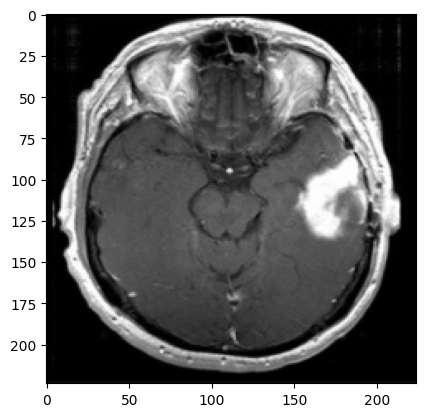

In [30]:
plt.imshow(data[30])


In [31]:
combined = list(zip(labels, data))
random.shuffle(combined)
shuffled_labels, shuffled_images = zip(*combined)

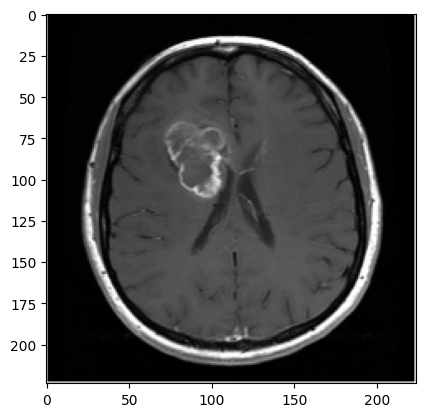

In [32]:
plt.imshow(shuffled_images[1])

In [33]:
shuffled_labels[1]


1

In [34]:
image_array = np.array(shuffled_images) 
labels_array = np.array(shuffled_labels)

In [35]:
#split the data

In [36]:
x_train, x_test, y_train, y_test = train_test_split(image_array, labels_array, test_size=0.1)


In [37]:
#data augmentation

In [38]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.3),
    keras.layers.RandomZoom(0.2)
])

In [39]:
callback = keras.callbacks.EarlyStopping(patience=50, monitor='loss')

In [40]:
#cnn

In [41]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.layers.Rescaling(1./255)(inputs)
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=output)

In [42]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [43]:
history = model.fit(x_train, y_train,epochs=20, validation_split=0.15, callbacks=[callback])

Epoch 1/20
6/6 [==============================] - 7s 798ms/step - loss: 0.6217 - accuracy: 0.6458 - val_loss: 0.5622 - val_accuracy: 0.7714
Epoch 2/20
6/6 [==============================] - 4s 620ms/step - loss: 0.5080 - accuracy: 0.7969 - val_loss: 0.3469 - val_accuracy: 0.8571
Epoch 3/20
6/6 [==============================] - 4s 607ms/step - loss: 0.4164 - accuracy: 0.8073 - val_loss: 0.3202 - val_accuracy: 0.9429
Epoch 4/20
6/6 [==============================] - 3s 556ms/step - loss: 0.3213 - accuracy: 0.8646 - val_loss: 0.2792 - val_accuracy: 0.9429
Epoch 5/20
6/6 [==============================] - 3s 558ms/step - loss: 0.2356 - accuracy: 0.9219 - val_loss: 0.2294 - val_accuracy: 0.9429
Epoch 6/20
6/6 [==============================] - 3s 547ms/step - loss: 0.1741 - accuracy: 0.9427 - val_loss: 0.3791 - val_accuracy: 0.8571
Epoch 7/20
6/6 [==============================] - 3s 553ms/step - loss: 0.0980 - accuracy: 0.9844 - val_loss: 0.2587 - val_accuracy: 0.9143
Epoch 8/20
6/6 [====

In [44]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                      

In [45]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 118ms/step - loss: 0.8769 - accuracy: 0.8077


[0.8769400715827942, 0.807692289352417]

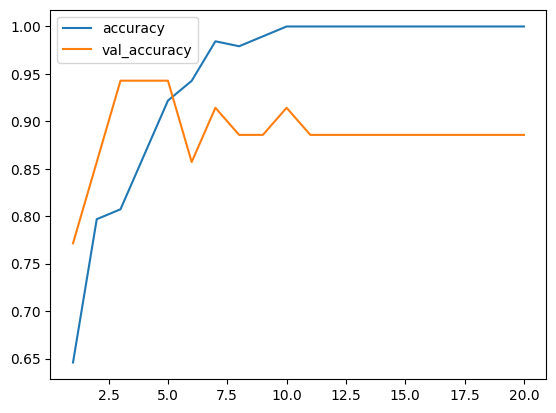

In [46]:
my_dict = history.history
number = range(1, len(my_dict['loss']) + 1)
accuracy = my_dict['accuracy']
val_accuracy = my_dict['val_accuracy']
plt.plot(number, accuracy, label='accuracy')
plt.plot(number, val_accuracy, label='val_accuracy')
plt.legend()

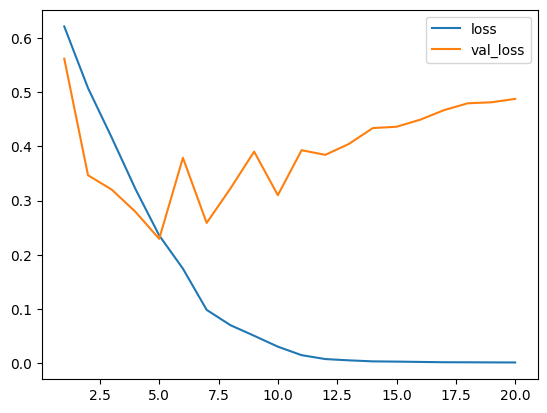

In [47]:
loss = my_dict['loss']
val_loss = my_dict['val_loss']
plt.plot(number, loss, label='loss')
plt.plot(number, val_loss, label='val_loss')
plt.legend()

In [48]:
y_pred = model.predict(x_test)  # Adjust X_test with your test data

from sklearn.metrics import accuracy_score
accuracy_score_value = accuracy_score(y_test, y_pred.round())
print("Accuracy:", accuracy_score_value)

1/1 [==============================] - 0s 149ms/step
Accuracy: 0.8076923076923077


In [49]:
from sklearn.metrics import precision_score
precision_score_value = precision_score(y_test, y_pred.round())
print("Precision:", precision_score_value)

Precision: 0.8421052631578947


In [50]:
from sklearn.metrics import f1_score
f1_score_value = f1_score(y_test, y_pred.round())
print("F1 Score:", f1_score_value)

F1 Score: 0.8648648648648649


In [51]:
from sklearn.metrics import recall_score
recall_score_value = recall_score(y_test, y_pred.round())
print("Recall:", recall_score_value)

Recall: 0.8888888888888888
